In [1]:
!conda create -n virtenv python=3.8 -y & conda init bash

no change     /anaconda/condabin/conda
no change     /anaconda/bin/conda
no change     /anaconda/bin/conda-env
no change     /anaconda/bin/activate
no change     /anaconda/bin/deactivate
no change     /anaconda/etc/profile.d/conda.sh
no change     /anaconda/etc/fish/conf.d/conda.fish
no change     /anaconda/shell/condabin/Conda.psm1
no change     /anaconda/shell/condabin/conda-hook.ps1
no change     /anaconda/lib/python3.8/site-packages/xontrib/conda.xsh
no change     /anaconda/etc/profile.d/conda.csh
no change     /home/azureuser/.bashrc
No action taken.


In [2]:
!pip3 install pandas_datareader


# Algorithmic trading with Keras

The goal of this notebook is to provide the necessary notions to perform time-series forecasting on financial data using the library Keras for Deep Learning. In particular, we will use two models involving LSTM recurrent neural networks and 1-dimensional convolutions to develop an investment strategy for the S&P 500 index.

We will test that, in a period of four years that includes the 2008 crisis, these deep learning strategies performed far better than the buy and hold strategy (stay always in the market) and the moving average strategy (stay in the market when the current price is greater than the moving average of the past 12 months and sell when it becomes smaller). To quantify these performances, we will compute the gross and net yield (considering the tax on capital gain and the fee to the broker at each transaction).

Throughout this notebook we will use the main libraries for machine learning in Python: *Pandas*, *Numpy*, *Scikit-learn*, *Keras*, and *Matplotlib*.


Note: investing in financial markets is very complicated and should only be done by experienced people. The author declines all responsibility for any losses.

In [3]:
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr

import azureml.core

import keras
from keras.models import Sequential
from keras.optimizers import RMSprop,Adam
from keras.layers import Dense,Dropout,BatchNormalization,Conv1D,Flatten,MaxPooling1D,LSTM
from keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard,ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


The notebook is divided in four parts, in which we will learn the following skills:
- [Download and manage financial data](#get_the_data): use *Pandas* to download S&P 500 data from Yahoo Finance and manage it, computing the moving averages
- [Define functions to compute gross and net yield](#compute_yield): use *Numpy* to define functions to compute gross and net yields in a clear and vectorized way
- [Define and train the two Deep Learning models](#train_models): use *Scikit-learn* to preprocess the data and define and train the Deep Learning models with *Keras*
- [Define a simple Deep Learning trading strategy and compare it with other ones](#compare): use *Matplotlib* to visualize the data and the portfolio growth

We will keep the investing strategy as simple and effective as possible. First, we will forecast the S&P 500 index on a monthly base, predicting at the first trading day of each month what will be the value of the index for the next month. Then, at the beginning of each month, based on our prediction, we will decide whether to "stay in the market" (i.e., invest in the index) or not. 

<a id='get_the_data'></a>
## Download and Manage Financial Data

We download the data of the S&P 500 index from Yahoo Finance. Our analysis is monthly-based, and all the decisions are made the first trading day of the month. For this reason, we fix the convention that *start_date* will always be the first day of a month and *end_date* will always be the last day of a month.

Our analysis will start from 24 months after the month of *start_date*, since we will use the first 24 months to produce the two-years moving average.

In [4]:
start_date=datetime.datetime(1973, 1, 1)
end_date=datetime.datetime(2021,2,28)

In [5]:
df = pdr.get_data_yahoo('^GSPC', start=start_date, end=end_date)
df.drop("Adj Close",axis=1,inplace=True)
print(df.tail())

                   High          Low         Open        Close      Volume
Date                                                                      
2021-02-22  3902.919922  3874.709961  3885.550049  3876.500000  5870190000
2021-02-23  3895.979980  3805.590088  3857.070068  3881.370117  6280650000
2021-02-24  3928.649902  3859.600098  3873.709961  3925.429932  5942350000
2021-02-25  3925.020020  3814.040039  3915.800049  3829.340088  6513060000
2021-02-26  3861.080078  3789.540039  3839.659912  3811.149902  6512950000


We need the list of the first trading day for each month, so we compute it:

In [6]:
start_year=start_date.year
start_month=start_date.month
end_year=end_date.year
end_month=end_date.month

first_days=[]
# First year
for month in range(start_month,13):
    first_days.append(min(df[str(start_year)+"-"+str(month)].index))
# Other years
for year in range(start_year+1,end_year):
    for month in range(1,13):
        first_days.append(min(df[str(year)+"-"+str(month)].index))
# Last year
for month in range(1,end_month+1):
    first_days.append(min(df[str(end_year)+"-"+str(month)].index))

For each month we need the means of the month, the first trading day of the current month (and its open price), and the first trading day of the next month (and its open price): our models will predict based on these data.

The feature *quot* is the quotient between the open price of the first trading day of the next month and the open price of the first trading day of the current month. It will be useful because it gives the variation of the portfolio for the current month.

Finally we add the columns corresponding to the moving averages at 1 and 2 years.

In [7]:
def monthly_df(df):

    dfm=df.resample("M").mean()
    dfm=dfm[:-1] # As we said, we do not consider the month of end_date
    
    dfm["fd_cm"]=first_days[:-1]
    dfm["fd_nm"]=first_days[1:]
    dfm["fd_cm_open"]=np.array(df.loc[first_days[:-1],"Open"])
    dfm["fd_nm_open"]=np.array(df.loc[first_days[1:],"Open"])
    dfm["quot"]=dfm["fd_nm_open"].divide(dfm["fd_cm_open"])
    
    dfm["mv_avg_12"]= dfm["Open"].rolling(window=12).mean().shift(1)
    dfm["mv_avg_24"]= dfm["Open"].rolling(window=24).mean().shift(1)
    
    dfm=dfm.iloc[24:,:] # we remove the first 24 months, since they do not have the 2-year moving average
    
    return dfm

In [8]:
dfm=monthly_df(df)

print(dfm.head())
print(dfm.tail())

#each month of dfm contains the moving averages of the previous 12 and 24 months (excluding the current month)
print(dfm.loc["1980-03","mv_avg_12"])
print(dfm.loc["1979-03":"1980-02","Open"])
print(dfm.loc["1979-03":"1980-02","Open"].mean())

                 High        Low  Open      Close        Volume      fd_cm  \
Date                                                                         
1975-01-31  73.546817  71.442273   0.0  72.564091  1.966136e+07 1975-01-02   
1975-02-28  80.988421  78.892106   0.0  80.096842  2.229684e+07 1975-02-03   
1975-03-31  84.783500  82.723500   0.0  83.831999  2.268050e+07 1975-03-03   
1975-04-30  85.649999  83.705001   0.0  84.723182  2.051591e+07 1975-04-01   
1975-05-31  91.089047  89.058096   0.0  90.096190  2.178524e+07 1975-05-01   

                fd_nm  fd_cm_open  fd_nm_open  quot  mv_avg_12  mv_avg_24  
Date                                                                       
1975-01-31 1975-02-03         0.0         0.0   NaN        0.0        0.0  
1975-02-28 1975-03-03         0.0         0.0   NaN        0.0        0.0  
1975-03-31 1975-04-01         0.0         0.0   NaN        0.0        0.0  
1975-04-30 1975-05-01         0.0         0.0   NaN        0.0        0.0

<a id='compute_yield'></a>
## Define Functions to Compute Gross and Net Yield

Notice that the gross yield can be computed very easily using the feature *quot* of the dataframe.
In the following function, the vector *v* selects which months we are going to stay in the market.

In [9]:
def yield_gross(df,v):
    prod=(v*df["quot"]+1-v).prod()
    n_years=len(v)/12
    return (prod-1)*100,((prod**(1/n_years))-1)*100

We now need to define a function to compute the net yield, considering (as it is by the Italian law) a 26% tax on capital gain and 0.10% commission to the broker at each transaction. Clearly these values can be changed to adapt the function to the tax system of other countries. 

In [10]:
tax_cg=0.26
comm_bk=0.001

The following function will be used to compute the net yield.

Given any vector of zeros and ones as input, *separate_ones* will return the sequence of vectors of groups of adjacent ones and a scalar equal to the number of groups of adjacent ones.

In [11]:
def separate_ones(u):
    
    u_ = np.r_[0,u,0]
    i = np.flatnonzero(u_[:-1] != u_[1:])
    v,w = i[::2],i[1::2]
    if len(v)==0:
        return np.zeros(len(u)),0
    
    n,m = len(v),len(u)
    o = np.zeros(n*m,dtype=int)

    r = np.arange(n)*m
    o[v+r] = 1

    if w[-1] == m:
        o[w[:-1]+r[:-1]] = -1
    else:
        o[w+r] -= 1

    out = o.cumsum().reshape(n,-1)
    return out,n

Let us clarify the behavior of this function with an example:

In [12]:
u=np.array([0,1,1,0,1,1,1,0,1])

In [13]:
separate_ones(u)

(array([[0, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1]]),
 3)

The following function is the one that we will use to compute the net yield.

Again, the vector *v* selects which months we are going to stay in the market.

In [14]:
def yield_net(df,v):
    n_years=len(v)/12
    
    w,n=separate_ones(v)
    A=(w*np.array(df["quot"])+(1-w)).prod(axis=1)  # A is the product of each group of ones of 1 for df["quot"]
    A1p=np.maximum(0,np.sign(A-1)) # vector of ones where the corresponding element if  A  is > 1, other are 0
    Ap=A*A1p # vector of elements of A > 1, other are 0
    Am=A-Ap # vector of elements of A <= 1, other are 0
    An=Am+(Ap-A1p)*(1-tax_cg)+A1p
    prod=An.prod()*((1-comm_bk)**(2*n)) 
    
    return (prod-1)*100,((prod**(1/n_years))-1)*100   

<a id='train_models'></a>
## Define and Train the Two Deep Learning Models

We will use two deep learning models to forecast the S&P 500 index: one, called *model_lstm*, which will be composed of LSTM recurrent neural networks, and one called *model_mix*, which will be composed of both LSTM and one-dimensional convolutional layers.

The first step will be to preprocess the financial data we acquired. In particular we will:
- create a window of data; recurrent neural networks take sequences as inputs and we will reshape the data accordingly. In particular, we will input to the model all data corresponding to the past six months. 
- scale the financial data in a range from 0 to 1, since recurrent neural networks work best with such data.
- divide the data into a train set and a test set; the latter will be the set on which we will compare the trading strategies. By default we will set this set to be 72 months long.

**Both our models will predict the value of the S&P 500 index for the first trading day of the following month, given all data of the past six months.**

In [15]:
def create_window(data, window_size = 1):    
    data_s = data.copy()
    for i in range(window_size):
        data = pd.concat([data, data_s.shift(-(i + 1))], axis = 1)
        
    data.dropna(axis=0, inplace=True)
    return(data)

In [16]:
def data_to_model(dfm):
    scaler=MinMaxScaler(feature_range=(0,1))
    dg=pd.DataFrame(scaler.fit_transform(dfm[["High","Low","Open","Close","Volume","fd_cm_open",\
                                          "mv_avg_12","mv_avg_24","fd_nm_open"]].values))
    X=dg[[0,1,2,3,4,5,6,7]]
    X=create_window(X,window)
    X=np.reshape(X.values,(X.shape[0],window+1,8))
    
    y=np.array(dg[8][window:])
    
    return X,y

The input data for the model will be a tensor of shape: 

(# months, window +1, # features)

The output data of the model will be a single vector of length # months:

In [17]:
window=5

X,y=data_to_model(dfm)
print(X.shape,y.shape)

(548, 6, 8) (548,)


In [18]:
mtest=72

X_train=X[:-mtest-1,:,:]
X_test=X[-mtest-1:,:,:]
y_train=y[:-mtest-1]
y_test=y[-mtest-1:]

In [19]:
def model_lstm(window,features):
    
    model=Sequential()
    model.add(LSTM(300, input_shape = (window,features), return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(200,  return_sequences=False)) # there is no need to specify input_shape here
    model.add(Dropout(0.5))
    model.add(Dense(100,kernel_initializer='uniform',activation='relu'))        
    model.add(Dense(1,kernel_initializer='uniform',activation='relu'))
    model.compile(loss='mse',optimizer=Adam(lr=0.001))
    
    
    return model

In [20]:
def model_mix(window,features):
    
    model=Sequential()
    model.add(Conv1D(input_shape=(window,features),filters=32,kernel_size=2,strides=1,activation='relu',padding='same'))
    model.add(Conv1D(filters=64,kernel_size=2,strides=1,activation='relu',padding='same'))
    model.add(LSTM(300, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(200,  return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(100,kernel_initializer='uniform',activation='relu'))        
    model.add(Dense(1,kernel_initializer='uniform',activation='relu'))
    model.compile(loss='mse',optimizer=Adam(lr=0.001))
    
    
    return model

In [21]:
model_lstm=model_lstm(window+1,8)
print(model_lstm.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6, 300)            370800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 300)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               400800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 791,801
Trainable params: 791,801
Non-trainable params: 0
________________________________________________

We will use the following Keras callback to reduce the learning rate as the training progresses:

In [22]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=25, verbose=1,\
                                                 factor=0.25, min_lr=0.00001)

Here, we can start the training for 400 epochs:

In [23]:
history_lstm=model_lstm.fit(X_train,y_train,epochs=400, batch_size=24, validation_data=(X_test, y_test), \
                  verbose=1, callbacks=[learning_rate_reduction],shuffle=False)

Train on 475 samples, validate on 73 samples
Epoch 1/400
475/475 [==============================] - 2s 5ms/step - loss: 0.0419 - val_loss: 0.0556
Epoch 2/400
475/475 [==============================] - 1s 2ms/step - loss: 0.0101 - val_loss: 0.0202
Epoch 3/400
475/475 [==============================] - 1s 2ms/step - loss: 0.0031 - val_loss: 0.0165
Epoch 4/400
475/475 [==============================] - 1s 2ms/step - loss: 0.0034 - val_loss: 0.0244
Epoch 5/400
475/475 [==============================] - 1s 2ms/step - loss: 0.0052 - val_loss: 0.0554
Epoch 6/400
475/475 [==============================] - 1s 2ms/step - loss: 0.0037 - val_loss: 0.0630
Epoch 7/400
475/475 [==============================] - 1s 2ms/step - loss: 0.0040 - val_loss: 0.0290
Epoch 8/400
475/475 [==============================] - 1s 2ms/step - loss: 0.0030 - val_loss: 0.0091
Epoch 9/400
475/475 [==============================] - 1s 2ms/step - loss: 0.0015 - val_loss: 0.0169
Epoch 10/400
475/475 [========================

In the following plot, we can visualize the train and test losses as the training progresses:

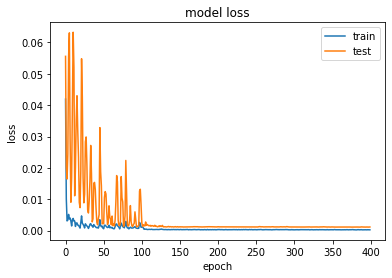

In [24]:
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [25]:
model_lstm.save_weights("lstm_weights.h5")

In [26]:
model_mix=model_mix(window+1,8)
print(model_mix.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 6, 32)             544       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 6, 64)             4160      
_________________________________________________________________
lstm_3 (LSTM)                (None, 6, 300)            438000    
_________________________________________________________________
dropout_3 (Dropout)          (None, 6, 300)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 200)               400800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)              

Here, we can start the training for 400 epochs:

In [27]:
history_mix=model_mix.fit(X_train,y_train,epochs=400, batch_size=24, validation_data=(X_test, y_test), \
                  verbose=1, callbacks=[learning_rate_reduction],shuffle=False)

Train on 475 samples, validate on 73 samples
Epoch 1/400
475/475 [==============================] - 2s 5ms/step - loss: 0.0563 - val_loss: 0.4943
Epoch 2/400
475/475 [==============================] - 1s 2ms/step - loss: 0.0563 - val_loss: 0.4943
Epoch 3/400
475/475 [==============================] - 1s 2ms/step - loss: 0.0563 - val_loss: 0.4943
Epoch 4/400
475/475 [==============================] - 1s 3ms/step - loss: 0.0563 - val_loss: 0.4943
Epoch 5/400
475/475 [==============================] - 1s 2ms/step - loss: 0.0563 - val_loss: 0.4943
Epoch 6/400
475/475 [==============================] - 1s 2ms/step - loss: 0.0563 - val_loss: 0.4943
Epoch 7/400
475/475 [==============================] - 1s 3ms/step - loss: 0.0563 - val_loss: 0.4943
Epoch 8/400
475/475 [==============================] - 1s 2ms/step - loss: 0.0563 - val_loss: 0.4943
Epoch 9/400
475/475 [==============================] - 1s 2ms/step - loss: 0.0563 - val_loss: 0.4943
Epoch 10/400
475/475 [========================

In the following plot, we can visualize the train and test losses as the training progresses:

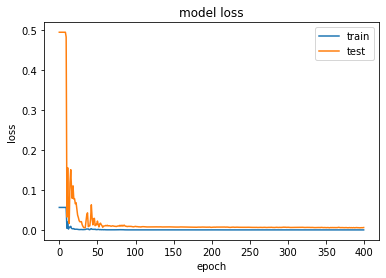

In [28]:
plt.plot(history_mix.history['loss'])
plt.plot(history_mix.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [29]:
model_mix.save_weights("mix_weights.h5")

In [30]:
y_pred_train_lstm=model_lstm.predict(X_train)
y_pred_train_mix=model_mix.predict(X_train)

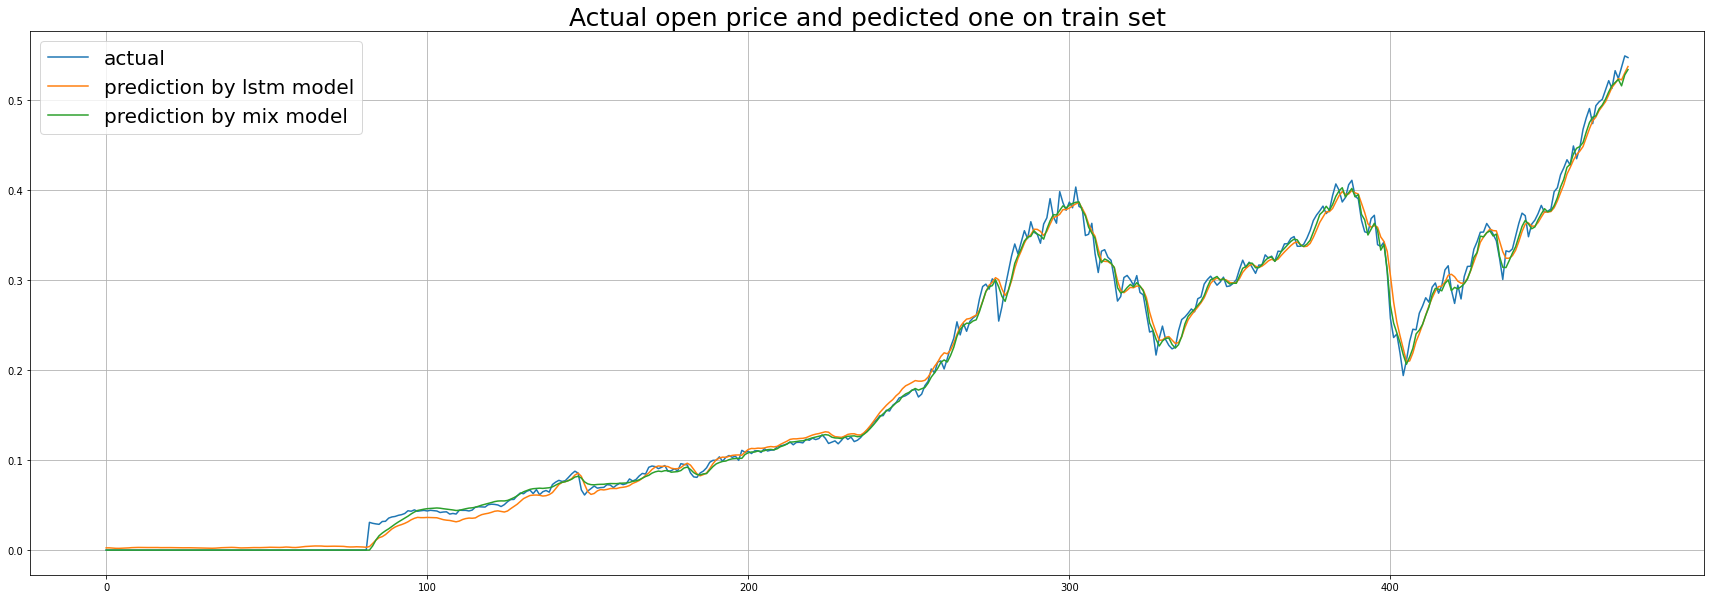

In [31]:
plt.figure(figsize=(30,10))
plt.plot(y_train, label="actual")
plt.plot(y_pred_train_lstm, label="prediction by lstm model")
plt.plot(y_pred_train_mix, label="prediction by mix model")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.title("Actual open price and pedicted one on train set",fontsize=25)
plt.show()

<a id='compare'></a>
## Define a Simple Deep Learning Trading Strategy and Compare It with Other Ones

Now that we have defined and trained our deep learning forecasting models, we can develop our investing strategy.
The first thing to do will be to predict the value of the S&P 500 index for the next month on the test-set.

In [32]:
y_pred_lstm=model_lstm.predict(X_test)
y_pred_mix=model_mix.predict(X_test)

Our trading strategy will be the simplest one possible: 

**We stay in the market when the predicted price for the next month is greater than the current price and stay out otherwise. The vectors v indicate the "in months" (as 1s) and "out months" (as 0s)**

In [33]:
w_lstm=np.diff(y_pred_lstm.reshape(y_pred_lstm.shape[0]),1)
v_lstm=np.maximum(np.sign(w_lstm),0)

w_mix=np.diff(y_pred_mix.reshape(y_pred_mix.shape[0]),1)
v_mix=np.maximum(np.sign(w_mix),0)

Here, we plot the in and out months for each month in the test-set.

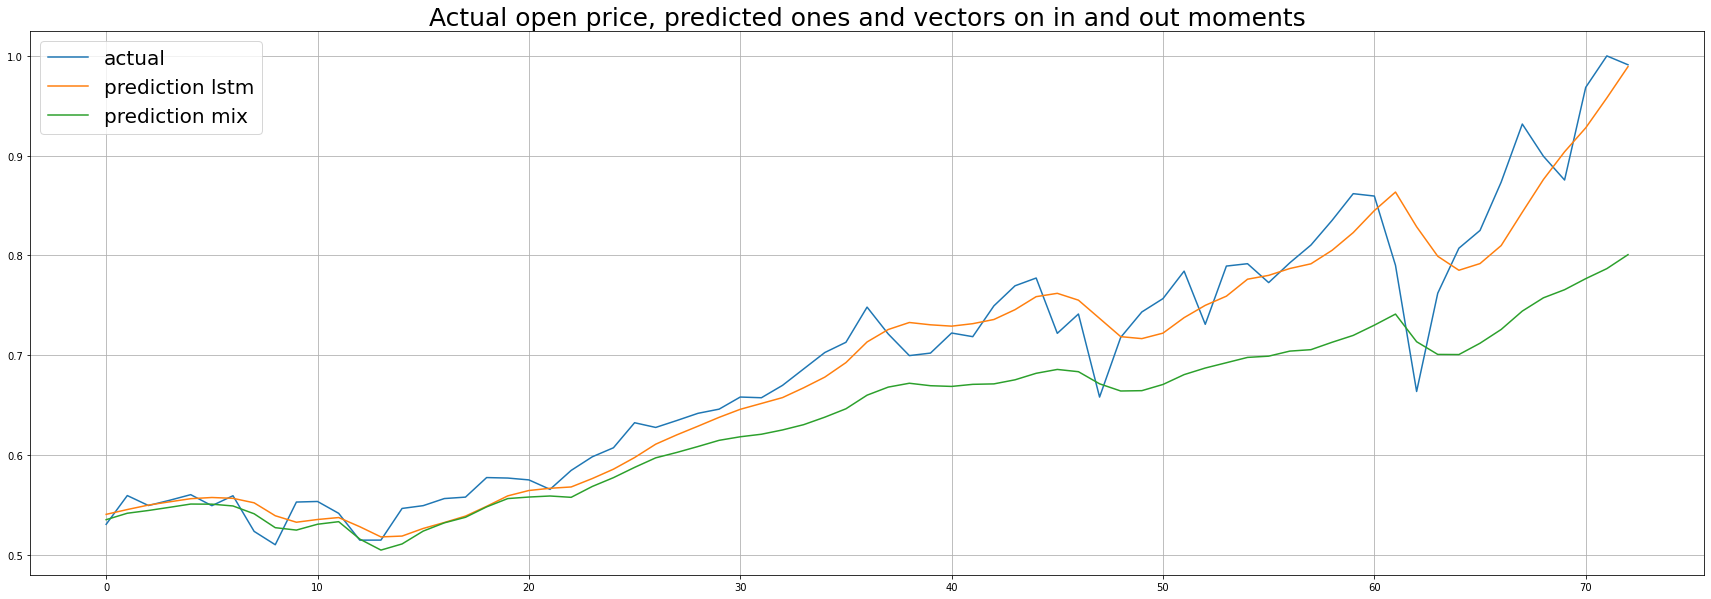

In [34]:
plt.figure(figsize=(30,10))
plt.plot(y_test, label="actual")
plt.plot(y_pred_lstm, label="prediction lstm")
#plt.plot(v_lstm,label="In and out lstm")
plt.plot(y_pred_mix, label="prediction mix")
#plt.plot(v_mix,label="In and out mix")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.title("Actual open price, predicted ones and vectors on in and out moments",fontsize=25)
plt.show()

**The preceeding plot shows an interesting feature of the prediction of our models: they are quite good at predicting the sign of the first derivative of the index, and this is exactly what we need for our trading strategy!** 

Now we can compare our deep learning trading strategies with the buy and hold strategy and the moving average strategy. In order to do so, we compute the corresponding vectors *v_bh* and *v_ma*, which select the months in which we are going to stay in the market.

In [35]:
test=dfm.iloc[-mtest:,:] 
v_bh=np.ones(test.shape[0])
v_ma=test["fd_cm_open"]>test["mv_avg_12"]

In [36]:
def gross_portfolio(df,w):
    portfolio=[ (w*df["quot"]+(1-w))[:i].prod() for i in range(len(w))]
    return portfolio

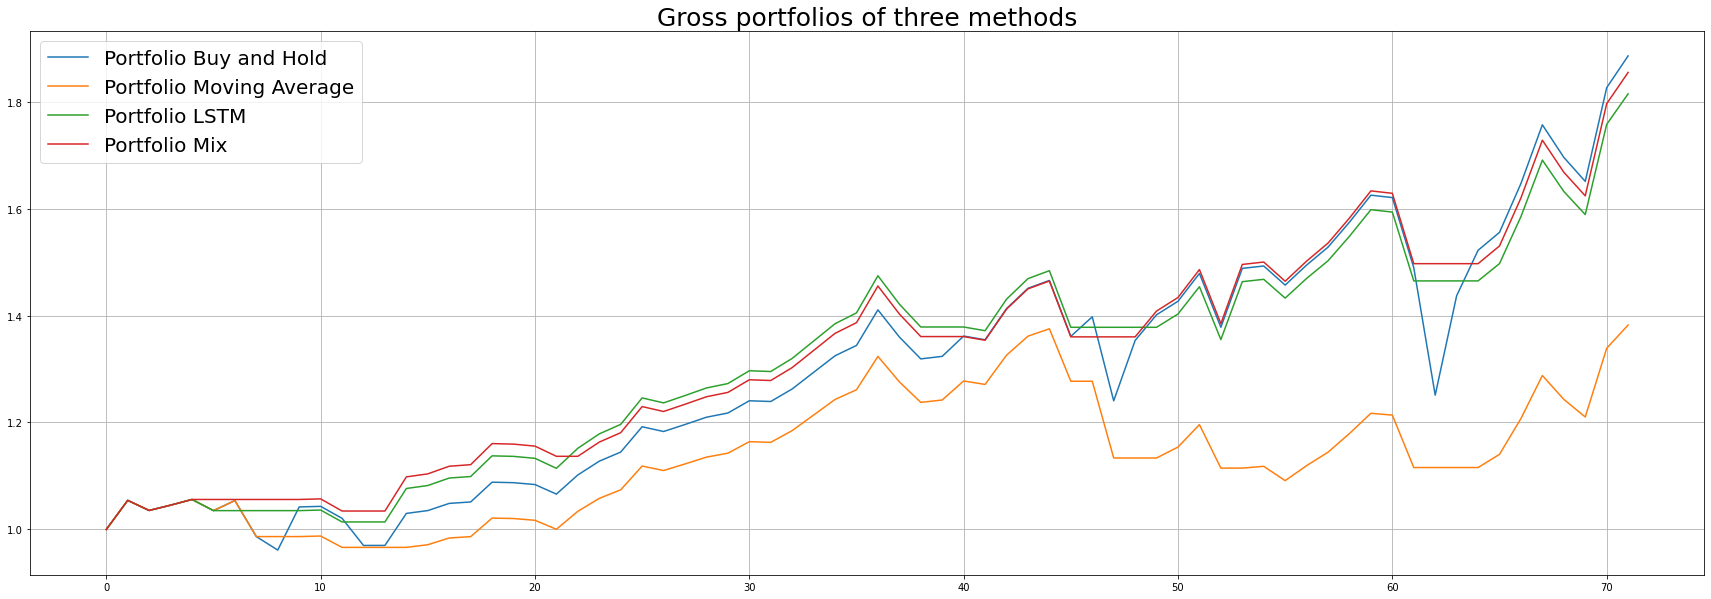

In [37]:
plt.figure(figsize=(30,10))
plt.plot(gross_portfolio(test,v_bh),label="Portfolio Buy and Hold")
plt.plot(gross_portfolio(test,v_ma),label="Portfolio Moving Average")
plt.plot(gross_portfolio(test,v_lstm),label="Portfolio LSTM")
plt.plot(gross_portfolio(test,v_mix),label="Portfolio Mix")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.title("Gross portfolios of three methods", fontsize=25)
plt.show()

Finally, we can see that our deep learning investing strategies performed far better on the test-set than the other two classical investing strategies.

In [38]:
print("Test period of {:.2f} years, from {} to {} \n".format(len(v_bh)/12,str(test.loc[test.index[0],"fd_cm"])[:10],\
      str(test.loc[test.index[-1],"fd_nm"])[:10]))

results=pd.DataFrame({})
results["Method"]=["Buy and hold","Moving average","LSTM","Mix"]

vs=[v_bh,v_ma,v_lstm,v_mix]
results["Total gross yield"]=[str(round(yield_gross(test,vi)[0],2))+" %" for vi in vs]
results["Annual gross yield"]=[str(round(yield_gross(test,vi)[1],2))+" %" for vi in vs]
results["Total net yield"]=[str(round(yield_net(test,vi)[0],2))+" %" for vi in vs]
results["Annual net yield"]=[str(round(yield_net(test,vi)[1],2))+" %" for vi in vs]

print(results)

Test period of 6.00 years, from 2015-02-02 to 2021-02-01 

           Method Total gross yield Annual gross yield Total net yield  \
0    Buy and hold           86.87 %            10.98 %         63.96 %   
1  Moving average            37.0 %             5.39 %         20.42 %   
2            LSTM           79.85 %            10.28 %          53.7 %   
3             Mix           83.81 %            10.68 %         55.25 %   

  Annual net yield  
0           8.59 %  
1           3.14 %  
2           7.43 %  
3           7.61 %  


<a id='compare'></a>
## Register and serve model 

This step will registry the model on Azure ML


In [39]:
from azureml.core import Workspace, Model
import joblib

ws = Workspace.from_config()
print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep='\n')

fmoz-workspace
ml
westus2
421b563f-a977-42aa-8934-f41ca5664b73


In [40]:
joblib.dump(y_pred_lstm, "pred_lstm.pkl")
joblib.dump(y_pred_mix, "pred_mix.pkl")

['pred_mix.pkl']

In [41]:
my_model_1 = Model.register(model_path="pred_lstm.pkl",
                            model_name="predict_sp500_lstm",
                            workspace=ws)

my_model_2 = Model.register(model_path="pred_mix.pkl",
                            model_name="predict_sp500_mix",
                            workspace=ws)

Registering model predict_sp500_lstm
Registering model predict_sp500_mix


In [42]:
%%writefile score.py
import joblib
import json
import numpy as np

from azureml.core.model import Model

def init():
    global model_1, model_2
    # Here "my_first_model" is the name of the model registered under the workspace.
    # This call will return the path to the .pkl file on the local disk.
    model_1_path = Model.get_model_path(model_name='predict_sp500_lstm')
    model_2_path = Model.get_model_path(model_name='predict_sp500_mix')
    
    # Deserialize the model files back into scikit-learn models.
    model_1 = joblib.load(model_1_path)
    model_2 = joblib.load(model_2_path)

# Note you can pass in multiple rows for scoring.
def run(raw_data):
    try:
        data = json.loads(raw_data)['data']
        data = np.array(data)
        
        # Call predict() on each model
        result_1 = model_1.predict(data)
        result_2 = model_2.predict(data)

        # You can return any JSON-serializable value.
        return {"prediction1": result_1.tolist(), "prediction2": result_2.tolist()}
    except Exception as e:
        result = str(e)
        return result

Overwriting score.py


In [43]:
from azureml.core import Environment

env = Environment("deploytocloudenv")
env.python.conda_dependencies.add_pip_package("joblib")
env.python.conda_dependencies.add_pip_package("numpy")
env.python.conda_dependencies.add_pip_package("pandas_datareader")

In [44]:
from azureml.core.model import InferenceConfig

inference_config = InferenceConfig(entry_script="score.py", environment=env)

In [45]:
from azureml.core.webservice import AciWebservice
from azureml.core.model import Model
from azureml.core import Workspace

ws = Workspace.from_config()

aci_service_name = "aciservice-multimodel"

deployment_config = AciWebservice.deploy_configuration(cpu_cores=1, memory_gb=1)

service = Model.deploy(ws, aci_service_name, [my_model_1, my_model_2], inference_config, deployment_config, overwrite=True)
service.wait_for_deployment(True)

print(service.state)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running.........................................................................
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


In [47]:
service.delete()

No service with name aciservice-multimodel found to delete.
